In [1]:
import sys
print("Versão python utilizada:",sys.version)

Versão python utilizada: 3.11.5 | packaged by Anaconda, Inc. | (main, Sep 11 2023, 13:26:23) [MSC v.1916 64 bit (AMD64)]


In [2]:
import os
print(os.getcwd())


C:\Users\Usuário


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from pulp import LpMinimize, LpProblem, LpVariable, lpSum
import joblib

In [4]:
file_path = "C:\Python\supply_chain_data.csv"
data = pd.read_csv(file_path)

In [5]:
data.head(11)

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632
5,haircare,SKU5,1.699976,87,147,2828.348746,Non-binary,90,27,66,...,Bangalore,10,104,17,56.766476,Fail,2.779194,Road,Route A,235.461237
6,skincare,SKU6,4.078333,48,65,7823.476560,Male,11,15,58,...,Kolkata,14,314,24,1.085069,Pending,1.000911,Sea,Route A,134.369097
7,cosmetics,SKU7,42.958384,59,426,8496.103813,Female,93,17,11,...,Bangalore,22,564,1,99.466109,Fail,0.398177,Road,Route C,802.056312
8,cosmetics,SKU8,68.717597,78,150,7517.363211,Female,5,10,15,...,Mumbai,13,769,8,11.423027,Pending,2.709863,Sea,Route B,505.557134
9,skincare,SKU9,64.015733,35,980,4971.145988,Unknown,14,27,83,...,Chennai,29,963,23,47.957602,Pending,3.844614,Rail,Route B,995.929461


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 
 14  Location                 10

In [7]:
print(data.isnull().sum())

Product type               0
SKU                        0
Price                      0
Availability               0
Number of products sold    0
Revenue generated          0
Customer demographics      0
Stock levels               0
Lead times                 0
Order quantities           0
Shipping times             0
Shipping carriers          0
Shipping costs             0
Supplier name              0
Location                   0
Lead time                  0
Production volumes         0
Manufacturing lead time    0
Manufacturing costs        0
Inspection results         0
Defect rates               0
Transportation modes       0
Routes                     0
Costs                      0
dtype: int64


In [8]:
data_cleaned = data.dropna()

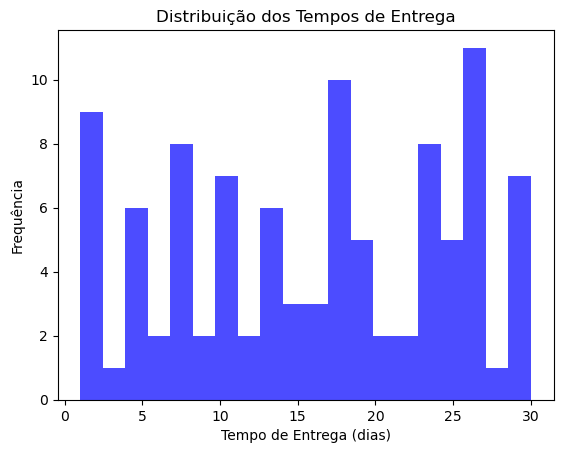

In [9]:
plt.hist(data_cleaned['Lead times'], bins=20, color='blue', alpha=0.7)
plt.title('Distribuição dos Tempos de Entrega')
plt.xlabel('Tempo de Entrega (dias)')
plt.ylabel('Frequência')
plt.show()

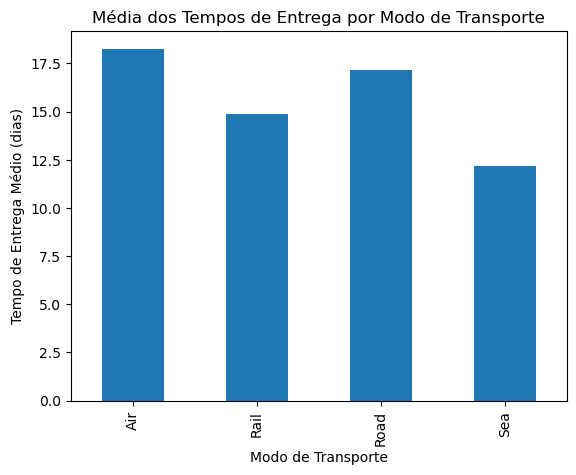

In [10]:
data_cleaned.groupby('Transportation modes')['Lead times'].mean().plot(kind='bar')
plt.title('Média dos Tempos de Entrega por Modo de Transporte')
plt.xlabel('Modo de Transporte')
plt.ylabel('Tempo de Entrega Médio (dias)')
plt.show()

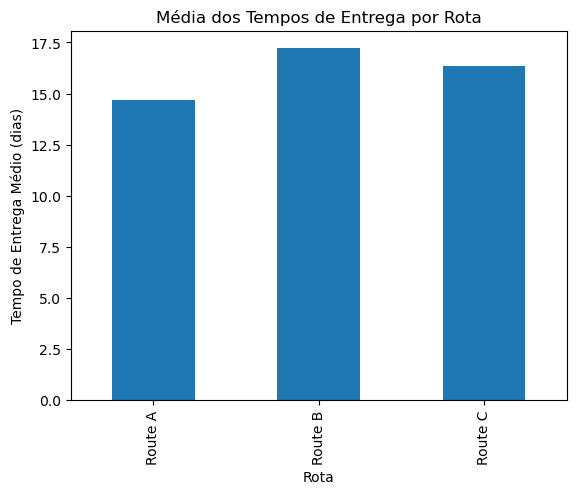

In [11]:
data_cleaned.groupby('Routes')['Lead times'].mean().plot(kind='bar')
plt.title('Média dos Tempos de Entrega por Rota')
plt.xlabel('Rota')
plt.ylabel('Tempo de Entrega Médio (dias)')
plt.show()

In [12]:
problem = LpProblem("Minimização_dos_Tempos_de_Entrega", LpMinimize)

In [13]:
rotas = data_cleaned['Routes'].unique()
modos_transporte = data_cleaned['Transportation modes'].unique()

In [14]:
x = LpVariable.dicts("x", [(rota, modo) for rota in rotas for modo in modos_transporte], lowBound=0, cat='Continuous')

In [15]:
problem += lpSum([x[(rota, modo)] * data_cleaned.loc[(data_cleaned['Routes'] == rota) & 
                                                     (data_cleaned['Transportation modes'] == modo), 
                                                     'Lead times'].mean() 
                  for rota in rotas for modo in modos_transporte])

In [16]:
for rota in rotas:
    problem += lpSum([x[(rota, modo)] for modo in modos_transporte]) >= 1


In [17]:
problem.solve()

1

In [18]:
print(f"Status: {problem.status}")

Status: 1


In [19]:
for v in problem.variables():
    print(f"{v.name} = {v.varValue}")

x_('Route_A',_'Air') = 0.0
x_('Route_A',_'Rail') = 1.0
x_('Route_A',_'Road') = 0.0
x_('Route_A',_'Sea') = 0.0
x_('Route_B',_'Air') = 0.0
x_('Route_B',_'Rail') = 0.0
x_('Route_B',_'Road') = 0.0
x_('Route_B',_'Sea') = 1.0
x_('Route_C',_'Air') = 0.0
x_('Route_C',_'Rail') = 0.0
x_('Route_C',_'Road') = 0.0
x_('Route_C',_'Sea') = 1.0


In [20]:
print(f"Tempo total de entrega minimizado: {problem.objective.value()}")


Tempo total de entrega minimizado: 32.761904761904766


In [25]:
model_filename = 'C:\\Users\\Usuário\\modelo_otimizacao_logistica.pkl'
joblib.dump(problem, model_filename)

['C:\\Users\\Usuário\\modelo_otimizacao_logistica.pkl']

In [26]:
##Análise mais detalhada: Podemos examinar quais rotas e modos de transporte foram escolhidos pelo modelo, 
##para entender como o tempo total foi minimizado.

In [27]:
for v in problem.variables():
    if v.varValue > 0:  # Apenas mostrar as variáveis que foram selecionadas (valor > 0)
        print(f"Rota e Modo de Transporte selecionados: {v.name} = {v.varValue}")

Rota e Modo de Transporte selecionados: x_('Route_A',_'Rail') = 1.0
Rota e Modo de Transporte selecionados: x_('Route_B',_'Sea') = 1.0
Rota e Modo de Transporte selecionados: x_('Route_C',_'Sea') = 1.0
